In [1]:
# Simulation for spiking model in Stringer et al., 2016.

from brian2 import * 

defaultclock.dt = 0.75*ms

# Network parameters

NE = 512


tau_m = 20*ms ;

tau_e = 5.1*ms ; tau_i = 3.75*ms ; tau_a = 375*ms

tau_f = 1*ms

el = 0 ; vth = 1
ee = 2*vth ; ei = -0.5*vth ; ea = -0.5*vth

wi = 0.22 ; wa = 0.8 ; we = 4.5
b0 = 0.013 ; b1 = 0.03 ; c = 0.25


# Neural network model
eqns_neurons = '''
dv/dt = (-(v-el)*(v-vth) - ge*(v-ee) - gi_tot*(v-ei) - ga*(v-ea))/tau_m : 1
dge/dt = (-ge + b)/tau_e : 1
dga/dt = (-ga/tau_a) : 1
gi_tot : 1 (linked)
b : 1
'''

eqns_inh = '''
dgi_tot/dt = (-gi_tot)/tau_i  : 1
ss : 1
'''

# create neuron groups
Pe = NeuronGroup(NE, eqns_neurons, threshold='v > vth', reset='v = 0.9*vth; ga+= wa', method='euler') 
Pe.v = numpy.random.uniform(ei,vth,NE)
Pe.ga = 0.0
Pe.ge = numpy.random.uniform(b0,b1,NE)
Pe.b = b0 + np.random.exponential(b1,NE)


Pi = NeuronGroup(1, eqns_inh, events={'custom_event': 'ss>0'}, method='euler')
Pi.run_on_event('custom_event', '''ss=0''')
Pi.gi_tot = 0.0

Pe.gi_tot = linked_var(Pi, 'gi_tot')


# make connections
Cee = Synapses(Pe, Pe, model='w:1', on_pre='ge_post+=w')
Cee.connect(p=0.05)
Cee.w = np.random.uniform(0,we,len(Cee))


Cei=Synapses(Pe,Pi, on_pre = {'get_spikes': 'ss += 1',
                              'gi_up': 'gi_tot += wi*(exp(c*ss) - 1)'})
Cei.connect()
Cei.get_spikes.order = -2
Cei.ss = 0

@network_operation()
def rect_voltage():  
    Pe.v[Pe.v < ei] = ei

M = SpikeMonitor(Pe,'v')
Sv = StateMonitor(Pe, 'v', record=[0,1,2,3,4,5,6,7,8,9,10])
Sa = StateMonitor(Pe, 'ga', record=[0,1])
Sge = StateMonitor(Pe, 'ge', record=[0,1,2,3,4,5,6,7,8,9,10])
Si = StateMonitor(Pe, 'gi_tot', record=[0])
Sss = StateMonitor(Pi, 'ss', record=[0])

run(5*second)

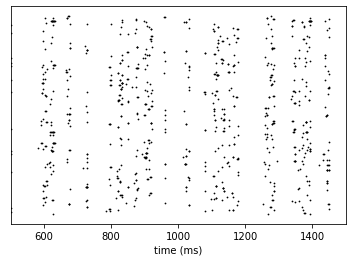

In [9]:
i, t = M.it
plot(t/ms, i, 'k.', ms=1.5)
xlabel("time (ms)")
yticks([])
xlim(500, 1500)
show()

(0, 10000)

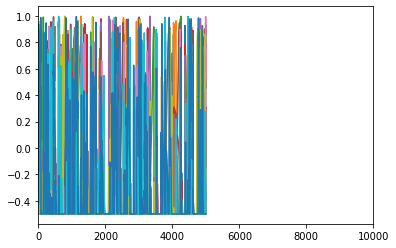

In [3]:
plot(Sv.t / ms, Sv.v.T )
xlim(0, 10000)

(0, 10000)

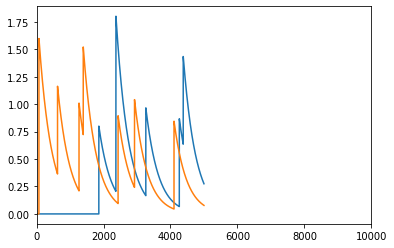

In [4]:
plot(Sa.t / ms, Sa.ga.T )
xlim(0, 10000)

(0, 10000)

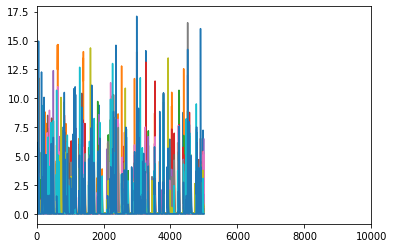

In [5]:
plot(Sge.t / ms, Sge.ge.T )
xlim(0, 10000)

(0, 10000)

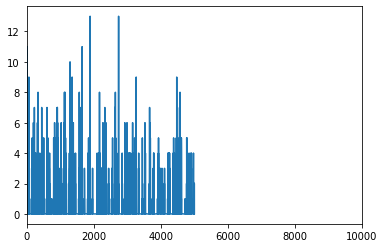

In [6]:
plot(Sss.t / ms, Sss.ss.T )
xlim(0,10000)

(0, 10000)

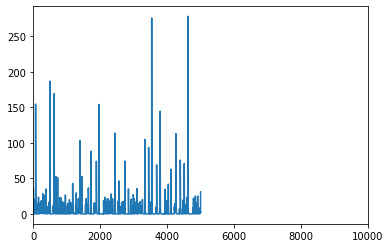

In [7]:
plot(Si.t / ms, Si.gi_tot.T )
xlim(0,10000)